# TP: Building an MLP from Scratch for CIFAR-10 Classification

_Adapted from [Dataflowr Module 5](https://dataflowr.github.io/website/modules/5-stacking-layers/#practicals) by Marc Lelarge_ 

In this practical, you will implement a Multi-Layer Perceptron (MLP) from scratch using PyTorch to classify images from the CIFAR-10 dataset.

## System Setup

Import the required packages and check PyTorch version.

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0
Torchvision version: 0.25.0
CUDA available: False


## Part 1: Building the Dataset

### About CIFAR-10

CIFAR-10 is a dataset of 32x32 color images in 10 classes:
- **Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- **Training images**: 50,000 (5,000 per class)
- **Test images**: 10,000 (1,000 per class)
- **Image size**: 32x32 pixels, RGB (3 channels)

### Data Preprocessing

For an MLP, we need to:
1. Convert images to tensors
2. Normalize pixel values (mean=0.5, std=0.5 for each channel)
3. Flatten 32x32x3 images into 1D vectors of size 3072

**TODO 1:** Create a transform pipeline using `transforms.Compose` that:
- Converts images to tensors with `transforms.ToTensor()`
- Normalizes with `transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))`

In [3]:
# ImageNet normalization statistics
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

### Loading CIFAR-10 Dataset

**TODO 2:** Load the CIFAR-10 dataset using `datasets.CIFAR10`.

Hints:
- Set `root='./data'` to specify download directory
- Set `train=True` for training set, `train=False` for test set
- Set `download=True` to download the dataset
- Use the transform pipeline you created above

Check the documentation: [datasets.CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)

In [4]:
root = './data'
train_dataset = datasets.CIFAR10(root=root, train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root=root, train=False, transform=transform, download=True)

/Users/mla/cloud/fac/m2.s2/.venv/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


### Check Dataset Properties

**TODO 3:** Print the sizes of training and test datasets, and examine the class names.

In [5]:
# Check dataset sizes
dset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}
print(f"Training set size: {dset_sizes['train']}")
print(f"Test set size: {dset_sizes['test']}")
print(f"Classes: {train_dataset.classes}")
print(f"Number of classes: {len(train_dataset.classes)}")

Training set size: 50000
Test set size: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of classes: 10


### Creating DataLoaders

DataLoaders handle batching, shuffling, and parallel loading of data.

**TODO 4:** Create DataLoaders for training and testing.

Hints:
- Use `batch_size=128` for training
- Use `batch_size=100` for testing
- Set `shuffle=True` for training data
- Set `shuffle=False` for test data
- Set `num_workers=2` for parallel data loading

Check the documentation: [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [6]:
batch_size = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False, num_workers=2)

### Visualize Sample Images

**TODO 5:** Visualize a batch of training images using matplotlib.

Hints:
- Get a batch using `next(iter(train_loader))`
- Use `torchvision.utils.make_grid()` to create a grid of images
- Don't forget to denormalize before displaying (reverse the normalization)

Batch shape: torch.Size([64, 3, 32, 32])
Labels: tensor([5, 3, 2, 0, 0, 7, 9, 3])


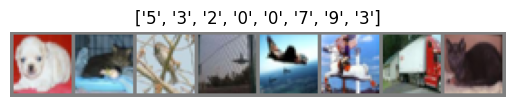

In [7]:
# Get a batch of training data
inputs, labels = next(iter(train_loader))

print(f"Batch shape: {inputs.shape}")
print(f"Labels: {labels[:8]}")

def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = np.clip(std * inp + mean, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Make a grid from batch
n_images = 8
out = torchvision.utils.make_grid(inputs[0:n_images])
imshow(out, title=[str(x.item()) for x in labels[0:n_images]])

## Part 2: Understanding MLP Architecture

### What is an MLP?

A Multi-Layer Perceptron (MLP) is a fully connected neural network consisting of:
- **Input layer**: Takes flattened input (3072 values for 32x32x3 images)
- **Hidden layers**: One or more layers that learn features
- **Output layer**: Produces class probabilities (10 values for CIFAR-10)

### Architecture Design

We will build an MLP with the following structure:

```
Input: 32x32x3 image → Flatten → 3072 values
   ↓
Linear(3072 → 1000)  [Weights: 3072×1000 + 1000 bias = 3,073,000 parameters]
   ↓
ReLU activation
   ↓
Linear(1000 → 10)    [Weights: 1000×10 + 10 bias = 10,010 parameters]
   ↓
Output: 10 class scores
```

**Total parameters**: ~3.08 million

### Understanding Dimensions

Each linear layer performs: `output = input @ weights.T + bias`

For a batch of size B:
- Input shape: `[B, 3072]`
- After first linear: `[B, 1000]`
- After second linear: `[B, 10]`

### Non-Linear Activation Functions

**Why do we need activation functions?**

Without non-linearity, stacking multiple linear layers is equivalent to a single linear layer:
```
Layer1(Layer2(x)) = W1(W2*x + b2) + b1 = (W1*W2)*x + (W1*b2 + b1) = W3*x + b3
```

**ReLU (Rectified Linear Unit)**: `ReLU(x) = max(0, x)`
- Introduces non-linearity
- Computationally efficient
- Helps avoid vanishing gradient problem
- Most commonly used activation function

## Part 3: Building the MLP with PyTorch

### Using nn.Sequential

PyTorch provides `nn.Sequential` to stack layers sequentially. This is convenient for simple architectures.

**TODO 6:** Build the MLP model using `nn.Sequential` with:
1. `nn.Flatten()` - converts [B, 3, 32, 32] to [B, 3072]
2. `nn.Linear(3072, 1000)` - hidden layer
3. `nn.ReLU()` - activation function
4. `nn.Linear(1000, 10)` - output layer

Check the documentation:
- [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
- [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

In [8]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        # 1. Aplatir l'image (32x32x3) en un vecteur de 3072 éléments
        self.flatten = nn.Flatten()
        # 2. Première couche : de l'image (3072) vers le caché (512)
        self.fc1 = nn.Linear(input_size, hidden_size)
        # 3. Activation pour ajouter de la "complexité"
        self.relu = nn.ReLU()
        # 4. Deuxième couche : du caché (512) vers les classes (10)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # C'est ici que les données circulent
        # Étape A : On aplatit l'image (de 32x32x3 à 3072)
        x = self.flatten(x) # Flatten the input
        # Étape B : Passage dans les couches
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

### Verify Model Architecture

**TODO 7:** Print the model architecture and count the total number of parameters.

Hints:
- Print the model to see its structure
- Use `sum(p.numel() for p in model.parameters())` to count parameters

In [ ]:
print("Model architecture:")
model = SimpleMLP(input_size=3*32*32, hidden_size=512, output_size=10)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
# Entrée = 3*32*32 = 3072
# Nb de poids = 3072*512
# Nb de biais = 512 (1 par neurone)
# Total = 3072*512 + 512

Model architecture:
SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Total number of parameters: 1578506


### Test Forward Pass

**TODO 8:** Test the model with a random batch to verify dimensions.

Hints:
- Create a random tensor of shape `[4, 3, 32, 32]` (batch of 4 images)
- Pass it through the model
- Verify output shape is `[4, 10]`

In [ ]:
# 1. On crée un mini-lot de 4 images aléatoires
x_test = torch.randn(4, 3, 32, 32)

# 2. On les fait passer dans le modèle
output = model(x_test)

# 3. On vérifie la taille de la sortie
print(f"Dimensions de la sortie : {output.shape}")
# [4, 10] = 4 images, 10 scores de probabilité (1 par classe)

Dimensions de la sortie : torch.Size([4, 10])


## Part 4: Training the MLP

### Loss Function and Optimizer

**Loss Function**: We use Cross-Entropy Loss for multi-class classification
- Combines `LogSoftmax` and `NLLLoss`
- Measures the difference between predicted probabilities and true labels

**Optimizer**: We use Stochastic Gradient Descent (SGD)
- Updates weights in the direction that reduces loss
- Momentum helps accelerate convergence

**TODO 9:** Create the loss function and optimizer.

Hints:
- Use `nn.CrossEntropyLoss()`
- Use `torch.optim.SGD` with:
  - `lr=0.01` (learning rate)
  - `momentum=0.9`
  - `model.parameters()` to optimize all parameters

Check the documentation:
- [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [11]:
# La règle pour mesurer l'erreur (Classification)
criterion = nn.CrossEntropyLoss()

# L'algorithme qui ajuste les paramètres (SGD = Descente de Gradient Stochastique)
optimizer = optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)

### Training Loop

The training loop consists of:
1. **Forward pass**: Compute predictions
2. **Loss computation**: Calculate error
3. **Backward pass**: Compute gradients using `loss.backward()`
4. **Optimizer step**: Update weights using `optimizer.step()`
5. **Zero gradients**: Clear gradients with `optimizer.zero_grad()`

**TODO 10:** Implement the training function.

Hints:
- Set model to training mode: `model.train()`
- Loop over batches from the dataloader
- Move data to device (GPU/CPU)
- Perform forward pass, compute loss, backward pass, optimizer step
- Track running loss and accuracy
- Use `torch.max(outputs, 1)` to get predicted classes

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    # On active le mode entraînement
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        # On envoie les données sur le bon support (CPU ou GPU)
        images, labels = images.to(device), labels.to(device)
        
        # 1. On vide les gradients du tour précédent
        optimizer.zero_grad()

        # 2. Forward pass : le modèle fait sa prédiction
        outputs = model(images)
        
        # 3. Calcul de l'erreur (Loss)
        loss = criterion(outputs, labels)
        
        # 4. Backward pass : calcul de l'impact de chaque poids sur l'erreur (calculer les gradients)
        loss.backward()
        
        # 5. Step: Mise à jour des poids avec l'optimiseur
        optimizer.step()
        
        # Statistiques
        # On accumule la perte pour l'affichage
        running_loss += loss.item()
        
        # Calcul de la précision (Accuracy)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

### Train the Model

**TODO 11:** Train the model for 10 epochs.

Note: Training may take several minutes depending on your hardware.

Using device: cpu
Epoch [1/10] - Loss: 0.9122, Accuracy: 68.87%
Epoch [2/10] - Loss: 0.8792, Accuracy: 70.48%
Epoch [3/10] - Loss: 0.8474, Accuracy: 71.57%
Epoch [4/10] - Loss: 0.8027, Accuracy: 72.90%
Epoch [5/10] - Loss: 0.7672, Accuracy: 74.41%
Epoch [6/10] - Loss: 0.7439, Accuracy: 75.21%


## Part 5: Model Evaluation

### Test Function

**TODO 12:** Implement a function to evaluate the model on the test set.

Hints:
- Set model to evaluation mode: `model.eval()`
- Use `torch.no_grad()` to disable gradient computation
- Calculate test loss and accuracy
- Store predictions and probabilities for analysis

### Evaluate on Test Set

**TODO 13:** Run the test function and report accuracy.

## Next? 

What happens if you
- switch the training to a GPU? Is it faster?
- Remove the `ReLU()`? 
- Increase the learning rate?
- Stack more layers? 
- Perform more epochs?